<a href="https://colab.research.google.com/github/pgeorgantopoulos/PINNs-Photogrammetry/blob/main/pinn_min_example_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN minimal example <i>(Data-driven discovery of p.d.e)<i>

*This is a classical regression problem.*

Given the dynamics
$$
\dot{\pmb x} = \pmb f(\pmb x,t), \quad t \in [0,T]
$$

and a set of measurements $\{\pmb x_i,t_i\}_{i=0}^{N-1}$ (collocation points)

we seek to approximate $\pmb x(t)$ at any point $t \in [0,T]$.

e.g. Dynamics of Ballistic Trajectory (BT)
\begin{align}
    \dot{\pmb x} &= \pmb v(t)\\
    \dot{\pmb v} &= \pmb \lambda\ \Big(=
    \begin{bmatrix}
        0\\
        -9.81
    \end{bmatrix}\Big)
\end{align}

with the ground truth solution being

$$ \pmb x(t) = \pmb x_0 + \pmb v_0t - \dfrac{1}{2}\pmb \lambda t^2 $$

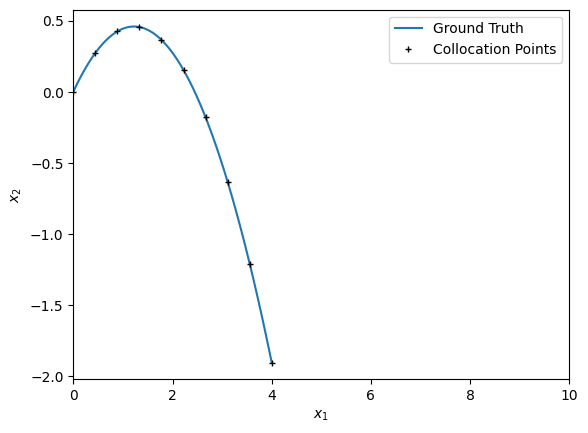

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torch

""" KNOWN """

def dxdtdt(t): # second derivative of x wrt t
    return torch.tensor([[0], [-9.81]])


""" UNKNOWN """

# unknown x(t)
def x(t): # noisy measurements
    t = t.view(-1,1)
    g = torch.tensor([0.0, -9.81]) # acceleration in x,y
    x0 = torch.tensor([0, 0]) # initial velocities in x,y
    dxdt0 = torch.tensor([4, 3])
    return (dxdt0*t + 0.5*g*t**2).T

# Collocation points
t_c = torch.Tensor(np.linspace(0, 1, 10))
x_c = x(t_c)# + torch.randn(2,len(t_c))*0.3

# Plots
t = torch.Tensor(np.linspace(0, 1, 100))
x_gt = x(t)
plt.plot(x_gt[0,:], x_gt[1,:], label='Ground Truth')
plt.plot(x_c[0,:].detach().numpy(), x_c[1,:].detach().numpy(), 'k+', markersize=5, label='Collocation Points')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim([0,10])
plt.legend()

## PINN approximation

Let $\pmb g(t;\pmb \theta,\pmb \lambda)$ aproximate $\pmb x(t)$.

$$ g \rightarrow x $$

$$ \underset{\theta}{\min} \underset{L_1}{\underbrace{\dfrac{1}{|S_1|}\sum_{S_1} ||\pmb g(t_i) - \pmb x_i||^2}} + \underset{L_2}{\underbrace{\sum_{S_2} ||\dfrac{d \pmb g}{dt}|_{t_i} - \pmb f(\pmb x_i,t_i;\pmb \lambda)||^2}} $$

$L_2$ imposes a classical smoothness constraint, since we have higher order information for the given measurements, that is the derivative of the solution $\pmb f(\pmb x,t)$.

Initialized nn with parameters:
prm_lambda: torch.Size([2, 1]):Parameter containing:
tensor([[0.],
        [0.]], requires_grad=True)
net.0.weight: torch.Size([5, 1]):Parameter containing:
tensor([[ 0.5542],
        [-0.7275],
        [ 0.8613],
        [-0.5749],
        [-0.7759]], requires_grad=True)
net.0.bias: torch.Size([5]):Parameter containing:
tensor([ 0.4052, -0.1623, -0.6035,  0.0530, -0.7763], requires_grad=True)
net.2.weight: torch.Size([2, 5]):Parameter containing:
tensor([[-0.3032, -0.0845,  0.2707, -0.3676,  0.3573],
        [-0.1337, -0.3681,  0.2156,  0.0790, -0.2676]], requires_grad=True)
net.2.bias: torch.Size([2]):Parameter containing:
tensor([-0.0409, -0.3800], requires_grad=True)
Epoch: 0, Loss: 1.2296879291534424
Epoch: 500, Loss: 0.03536351025104523
Epoch: 1000, Loss: 0.029970962554216385
Epoch: 1500, Loss: 0.02295784093439579
Epoch: 2000, Loss: 0.01212599128484726
Epoch: 2500, Loss: 0.005491448100656271
Epoch: 3000, Loss: 0.002700304612517357
Epoch: 3500, Loss

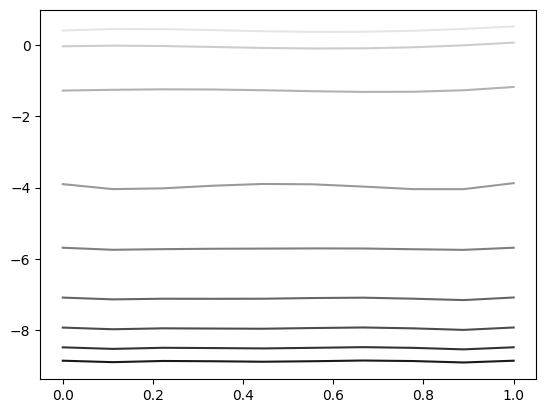

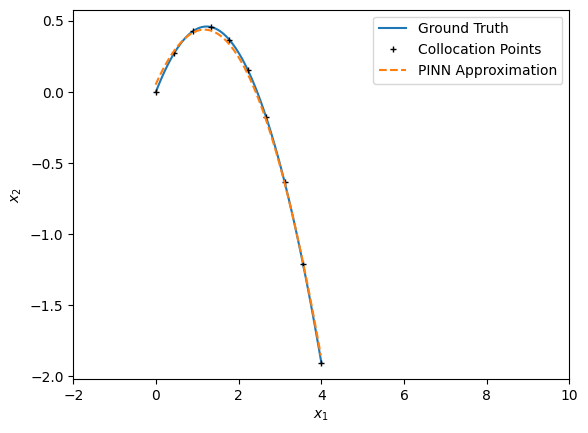

In [74]:
import torch.nn as nn

# Approximating function of x
class model(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(nn.Linear(1,5),
                                    nn.Tanh(),
                                    nn.Linear(5,2),
                                    # nn.Tanh()
                                    ).float()
        self.NUM_EPOCHS = 5000  # works best at 5000 @ 0.01 with no measurement noise. fist satisfying result at 2000 @ 0.01
        self.LR = 0.01
        self.prm_lambda = nn.Parameter(torch.zeros(2,1))
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.LR)

        print('Initialized nn with parameters:')
        print(*[f"{n}: {p.shape}:{p}" for n,p in self.named_parameters()], sep='\n')

    def forward(self,t):
        return self.net(t.view(-1,1)).T

g = model()
loss_fn = nn.MSELoss()
keep_dxdtdt = torch.zeros((2,len(t_c)))


t_c.requires_grad = True
for epoch in range(g.NUM_EPOCHS):
    g.optimizer.zero_grad()

    loss = 0.0
    for i,t_c_i in enumerate(t_c):
        x_i = g(t_c_i)
        dxdt_i = torch.zeros(2,1)
        dxdtdt_i = torch.zeros(2,1)
        dxdt_i[0] = torch.autograd.grad(x_i[0].squeeze(), t_c_i, create_graph=True)[0]
        dxdt_i[1] = torch.autograd.grad(x_i[1].squeeze(), t_c_i, create_graph=True)[0]
        dxdtdt_i[0] = torch.autograd.grad(dxdt_i[0].squeeze(), t_c_i, create_graph=True)[0]
        dxdtdt_i[1] = torch.autograd.grad(dxdt_i[1].squeeze(), t_c_i, create_graph=True)[0]
        keep_dxdtdt[:,[i]] = dxdtdt_i
        loss += (0.3*loss_fn(x_i, x_c[:,[i]]) + 0.7*loss_fn(dxdtdt_i, g.prm_lambda))/len(t_c)
    loss.backward()
    g.optimizer.step()

    if epoch % (g.NUM_EPOCHS*.1) == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')
        plt.figure(1)
        plt.plot(t_c.detach().numpy(), keep_dxdtdt[1,:].detach().numpy(),'k',alpha=epoch/g.NUM_EPOCHS)

plt.show()
# Plots
x_pred = g(t).detach().numpy()
plt.figure(2)
plt.plot(x_gt[0,:], x_gt[1,:], label='Ground Truth')
plt.plot(x_c[0,:].detach().numpy(), x_c[1,:].detach().numpy(), 'k+', markersize=5, label='Collocation Points')
plt.plot(x_pred[0,:], x_pred[1,:],'--', label='PINN Approximation')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim([-2,10])
plt.legend()